# Bank Marketing Data


The dataset in this project which is provided by Kaggle, was generated from a deep learning model trained on the Bank Marketing Dataset dataset (old version named "bank-full.csv").

### About the original dataset
Data was collected from May 2008 to November 2010 and donated on 2/13/2012

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The marketing campaigns were based on phone calls.

### Goal
The classification goal is to predict if the client will subscribe a term deposit (variable y).

### Variable Explaination Obtained from UCI

**age**

**job**

**marital** note: 'divorced' means divorced or widowed

**education**

**default** has credit in default?

**balance** average yearly balance

**housing** has housing loan?

**loan** has personal loan?

**contact**

**day** last contact day of the month

**month** last contact month of year

**duration** last contact duration, in seconds. Important note: **this attribute highly affects the output target** (e.g., if duration=0 then y='no'). **Yet, the duration is not known before a call is performed**. Also, after the end of the call y is obviously known. Thus, this input should **only be included for benchmark** purposes and should be **discarded if the intention is to have a realistic predictive model**.

**campaign** number of contacts performed during this campaign and for this client (includes last contact)	

**pdays** number of days that passed by after the client was last contacted from a previous campaign (numeric; -1 means client was not previously contacted)

**previous** number of contacts performed before this campaign and for this client	

**poutcome** outcome of the previous marketing campaign (UCI's categorical: 'failure',**'nonexistent'**,'success'; Kaggle's categorical: **"unknown","other"**,"failure","success")

**y** has the client subscribed a term deposit?	(1 = Yes, 0 = No)

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from matplotlib.ticker import FuncFormatter
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency, ks_2samp
from scipy.interpolate import make_interp_spline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from collections import Counter


# **EDA**

### Load Data

In [3]:
train = pd.read_csv("train.csv")

In [4]:
test = pd.read_csv("test.csv")

In [5]:
print(train.shape)
print(train.head())

(750000, 18)
   id  age          job  marital  education default  balance housing loan  \
0   0   42   technician  married  secondary      no        7      no   no   
1   1   38  blue-collar  married  secondary      no      514      no   no   
2   2   36  blue-collar  married  secondary      no      602     yes   no   
3   3   27      student   single  secondary      no       34     yes   no   
4   4   26   technician  married  secondary      no      889     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome  y  
0  cellular   25   aug       117         3     -1         0  unknown  0  
1   unknown   18   jun       185         1     -1         0  unknown  0  
2   unknown   14   may       111         2     -1         0  unknown  0  
3   unknown   28   may        10         2     -1         0  unknown  0  
4  cellular    3   feb       902         1     -1         0  unknown  1  


In [6]:
print(test.shape)
print(test.head())

(250000, 17)
       id  age            job  marital  education default  balance housing  \
0  750000   32    blue-collar  married  secondary      no     1397     yes   
1  750001   44     management  married   tertiary      no       23     yes   
2  750002   36  self-employed  married    primary      no       46     yes   
3  750003   58    blue-collar  married  secondary      no    -1380     yes   
4  750004   28     technician   single  secondary      no     1950     yes   

  loan   contact  day month  duration  campaign  pdays  previous poutcome  
0   no   unknown   21   may       224         1     -1         0  unknown  
1   no  cellular    3   apr       586         2     -1         0  unknown  
2  yes  cellular   13   may       111         2     -1         0  unknown  
3  yes   unknown   29   may       125         1     -1         0  unknown  
4   no  cellular   22   jul       181         1     -1         0  unknown  


In [7]:
print(train.duplicated().any())
print(test.duplicated().any())

False
False


In [8]:
train.isna().sum()

id           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [9]:
test.isna().sum()

id           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
dtype: int64

In [10]:
train.dtypes

id            int64
age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y             int64
dtype: object

In [11]:
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 
                    'loan', 'contact', 'month', 'poutcome']

numeric_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

### Target

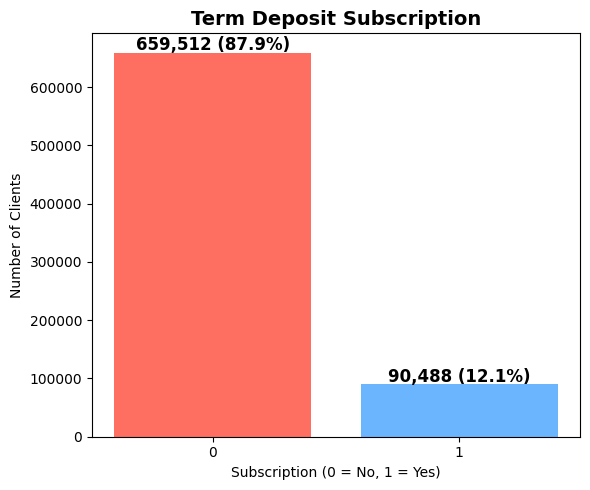

In [12]:
# Count and percentage
y_counts = train['y'].value_counts()
y_percent = (y_counts / len(train) * 100).round(1)

plt.figure(figsize=(6, 5))
bars = plt.bar(y_counts.index.astype(str), y_counts.values, color=['#FF6F61', '#6BB5FF'])

# Add labels on top of bars
for bar, percent in zip(bars, y_percent):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + len(train)*0.005,
             f'{bar.get_height():,} ({percent}%)',
             ha='center', fontsize=12, weight='bold')

plt.title('Term Deposit Subscription', fontsize=14, weight='bold')
plt.xlabel('Subscription (0 = No, 1 = Yes)')
plt.ylabel('Number of Clients')
plt.tight_layout()
plt.show()

### Categorical Data Overview

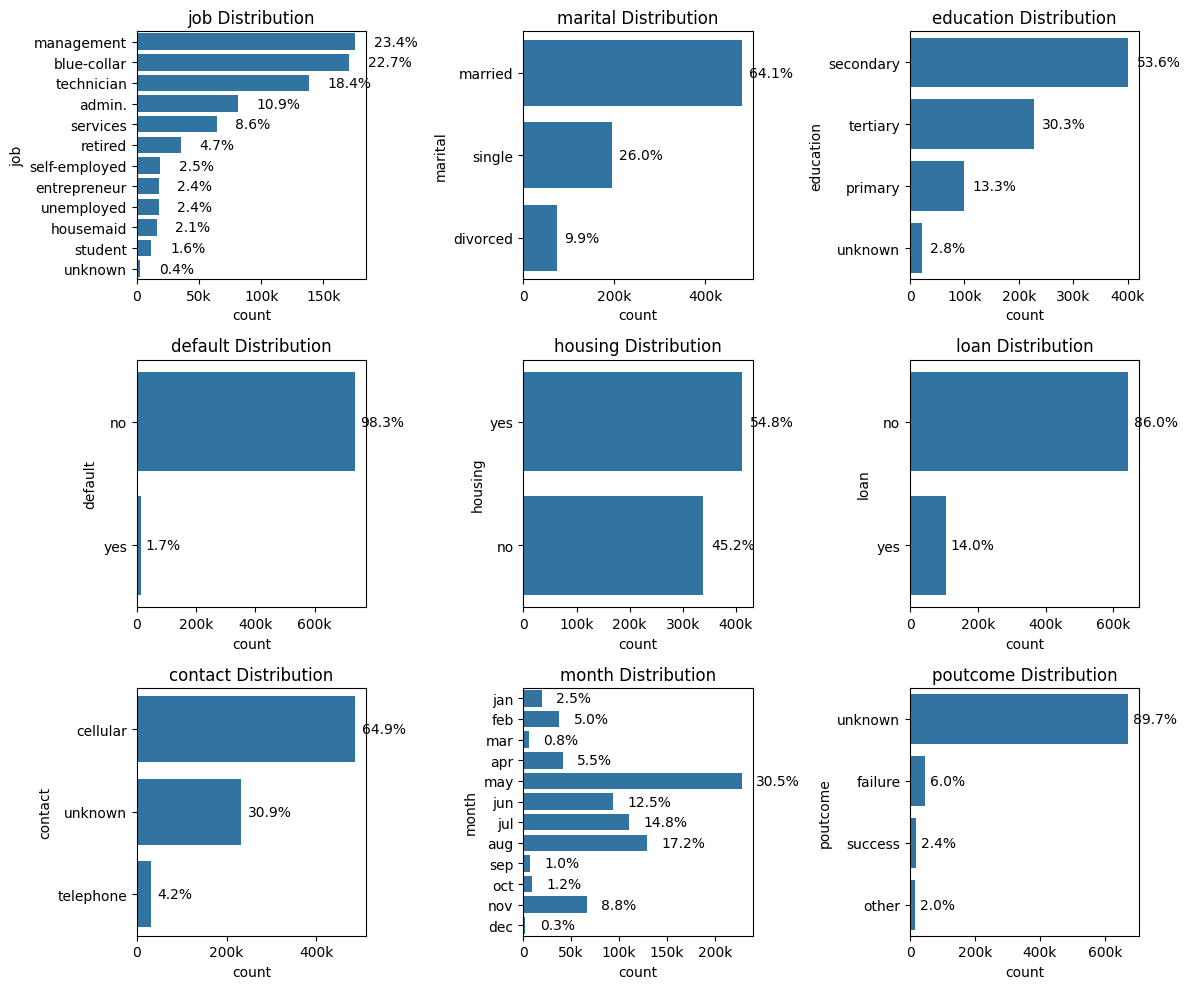

In [13]:
# Formatter function: 1000 → 1k
def format_thousands(x, pos):
    if x >= 1000:
        return f'{int(x/1000)}k'
    return int(x)

formatter = FuncFormatter(format_thousands)
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun',
               'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# Set up grid
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
axes = axes.flatten()

total_count = len(train)

for i, col in enumerate(categorical_cols):
    # Choose specific order for 'month', otherwise use value_counts
    if col == 'month':
        order = month_order
    else:
        order = train[col].value_counts().index

    ax = axes[i]
    sns.countplot(data=train, y=col, order=order, ax=ax)
    ax.set_title(f"{col} Distribution")
    ax.tick_params(axis='y', labelrotation=0)
    ax.xaxis.set_major_formatter(formatter)  # Apply 1k formatting

    # Add percentage labels on each bar
    for patch in ax.patches:
        width = patch.get_width()
        pct = (width / total_count) * 100
        ax.text(width + 0.02 * total_count,
                patch.get_y() + patch.get_height() / 2,
                f'{pct:.1f}%',  # one decimal place
                va='center')

# Hide unused subplots
for j in range(len(categorical_cols), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### Numeric Data Overview

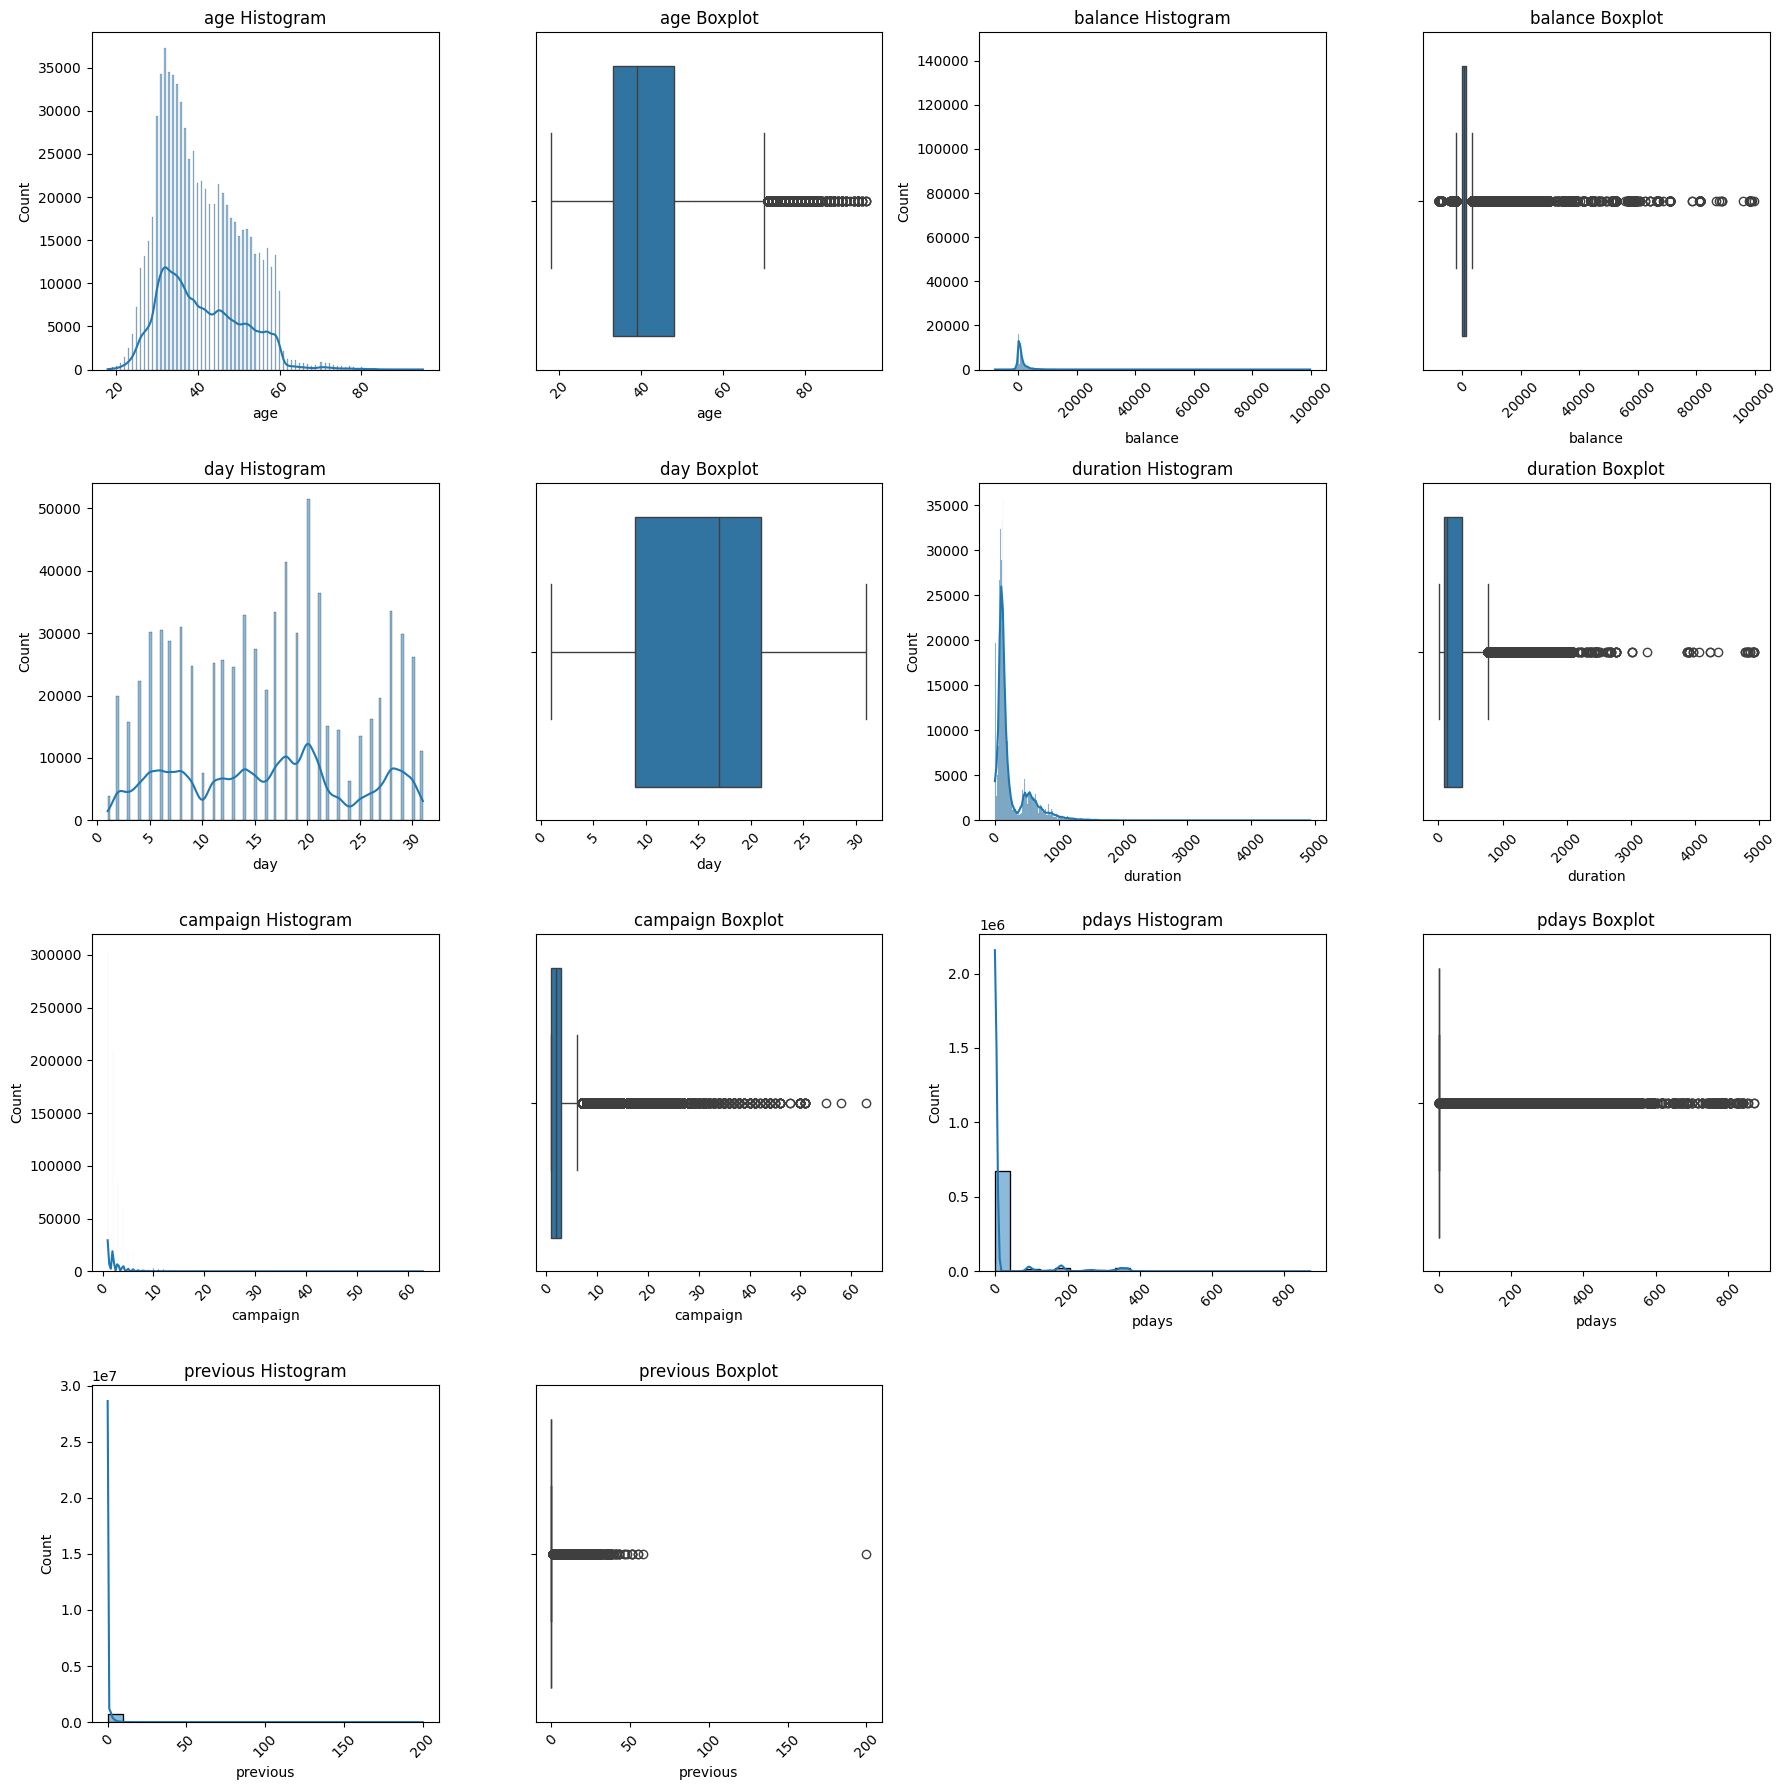

In [14]:
fig, axes = plt.subplots(4, 4, figsize=(18, 18))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    idx = i * 2
    sns.histplot(data=train, x=col, kde=True, ax=axes[idx])
    axes[idx].set_title(f"{col} Histogram")
    axes[idx].tick_params(axis='x', rotation=45)

    sns.boxplot(data=train, x=col, ax=axes[idx + 1])
    axes[idx + 1].set_title(f"{col} Boxplot")
    axes[idx + 1].tick_params(axis='x', rotation=45)

# Hide unused plots if any
for j in range(2 * len(numeric_cols), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### Data Drift Analysis

In [15]:
def detect_drift(train, test, categorical_cols, numeric_cols, alpha=0.05):
    drift = {}

    # Categorical: Chi-Square test
    for col in categorical_cols:
        table = pd.concat([train[col].value_counts(), test[col].value_counts()],
                          axis=1, keys=['Train', 'Test']).fillna(0)
        drift[col] = 1.0 if table.shape[0] == 1 else chi2_contingency(table)[1]

    # Numeric: KS test
    for col in numeric_cols:
        t, v = train[col].dropna(), test[col].dropna()
        drift[col] = np.nan if t.empty or v.empty else ks_2samp(t, v)[1]

    df = pd.DataFrame.from_dict(drift, orient='index', columns=['p_value'])
    df['drift'] = np.where(df['p_value'] < alpha, 'Yes', 'No')
    return df.sort_values('p_value', ascending=False)

# Example usage
drift_df = detect_drift(train, test, categorical_cols, numeric_cols)
print(drift_df)

            p_value drift
pdays      0.999985    No
previous   0.999961    No
day        0.991476    No
campaign   0.963708    No
month      0.915181    No
loan       0.802920    No
balance    0.727287    No
marital    0.650552    No
job        0.635926    No
duration   0.507043    No
contact    0.456695    No
age        0.419716    No
education  0.298338    No
poutcome   0.131458    No
default    0.093152    No
housing    0.050764    No


### Heatmap

In [16]:
df = train.copy()
total_rows = len(df)

for col in categorical_cols:
    # Compute relative frequency (as a percentage between 0 and 1)
    freq = df[col].value_counts(normalize=True)
    df[col + '_pct'] = df[col].map(freq)

In [17]:
df.columns

Index(['id', 'age', 'job', 'marital', 'education', 'default', 'balance',
       'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'y', 'job_pct', 'marital_pct',
       'education_pct', 'default_pct', 'housing_pct', 'loan_pct',
       'contact_pct', 'month_pct', 'poutcome_pct'],
      dtype='object')

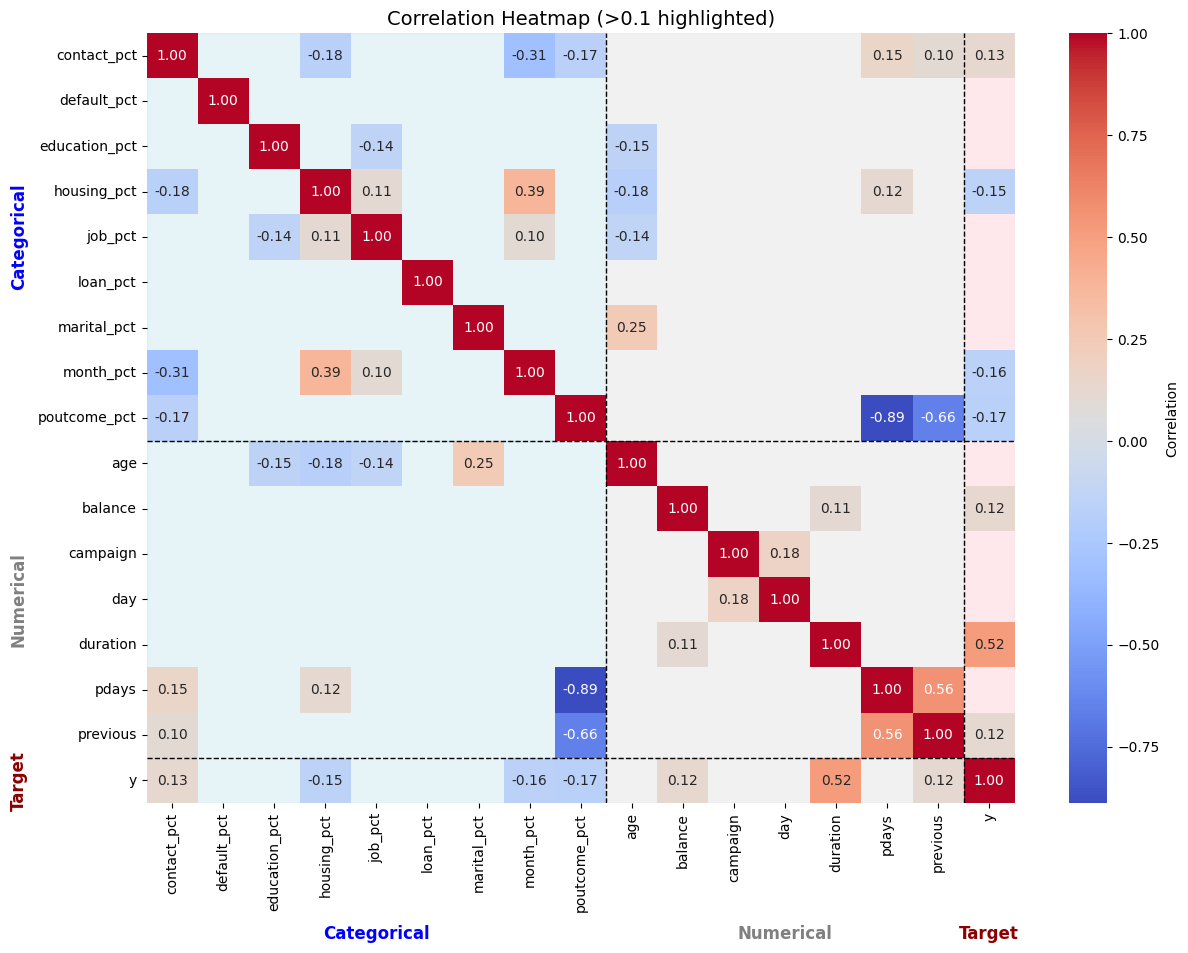

In [18]:
categorical_cols = sorted(['contact_pct', 'default_pct', 'education_pct', 'job_pct',
                           'loan_pct', 'marital_pct', 'month_pct', 'poutcome_pct','housing_pct'])
numerical_cols = sorted(['age', 'balance', 'campaign', 'day', 'duration', 'pdays', 'previous'])
target_col = ['y']

# Reorder columns
ordered_cols = categorical_cols + numerical_cols + target_col
df_ordered = df[ordered_cols]

# Compute correlation matrix
corr = df_ordered.corr()

# Mask small correlations
mask = np.abs(corr) <= 0.1

# Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", mask=mask, cbar_kws={'label': 'Correlation'})

# Draw group separators
cat_end = len(categorical_cols)
num_end = len(categorical_cols) + len(numerical_cols)

plt.axhline(cat_end, color='black', linestyle='--', linewidth=1)
plt.axhline(num_end, color='black', linestyle='--', linewidth=1)
plt.axvline(cat_end, color='black', linestyle='--', linewidth=1)
plt.axvline(num_end, color='black', linestyle='--', linewidth=1)

# Add colored background for groups using rectangles
from matplotlib.patches import Rectangle

ax = plt.gca()

# Categorical group background (light blue)
ax.add_patch(Rectangle((0, 0), cat_end, cat_end, fill=True, color='lightblue', alpha=0.3, zorder=-1))
ax.add_patch(Rectangle((0, cat_end), cat_end, len(ordered_cols)-cat_end, fill=True, color='lightblue', alpha=0.3, zorder=-1))

# Numerical group background (light green)
ax.add_patch(Rectangle((cat_end, 0), len(numerical_cols), num_end, fill=True, color='lightgray', alpha=0.3, zorder=-1))
ax.add_patch(Rectangle((cat_end, num_end), len(numerical_cols), len(target_col), fill=True, color='lightgray', alpha=0.3, zorder=-1))

# Target background (light pink)
ax.add_patch(Rectangle((num_end, 0), len(target_col), len(ordered_cols), fill=True, color='lightpink', alpha=0.3, zorder=-1))

# Add group labels on top
plt.text(cat_end/2, len(ordered_cols)+3, "Categorical", ha='center', fontsize=12, color='blue', fontweight='bold')
plt.text(cat_end + len(numerical_cols)/2, len(ordered_cols)+3, "Numerical", ha='center', fontsize=12, color='gray', fontweight='bold')
plt.text(num_end + 0.5, len(ordered_cols)+3, "Target", ha='center', fontsize=12, color='darkred', fontweight='bold')

# After drawing group labels on top
# Add group labels on the left
plt.text(-2.5, cat_end/2, "Categorical", va='center', ha='center', fontsize=12, color='blue', fontweight='bold', rotation=90)
plt.text(-2.5, cat_end + len(numerical_cols)/2, "Numerical", va='center', ha='center', fontsize=12, color='gray', fontweight='bold', rotation=90)
plt.text(-2.5, num_end + len(target_col)/2, "Target", va='center', ha='center', fontsize=12, color='darkred', fontweight='bold', rotation=90)


plt.title("Correlation Heatmap (>0.1 highlighted)", fontsize=14)
plt.show()

### contact

Unknown contacts are not strong predictors of subscription outcomes. However, they are strongly associated with brand-new customers.

Most new customers ('previous' == 0 and pdays == -1) was contacted by unknown type. This "unknown" type appear mainly in May and June with a significant number of phone call, which is unusual. By checking the duration of each contact (in seconds), it can be sure that the contact was actually made and recorded and "unknown" does not mean no contact.

There is posibility that there was campaigns during May-June targeting new customer and the system haven't recorded their primary contact method yet.

Action: Keep the column. Apply label encoding

In [19]:
# Total rows with contact = unknown
total_unknown = df[df['contact'] == 'unknown'].shape[0]

# Rows that are brand new AND contact = unknown
brand_new_unknown = df[
    (df['contact'] == 'unknown') &
    (df['previous'] == 0) &
    (df['pdays'] == -1)
].shape[0]

# Proportion
proportion = brand_new_unknown / total_unknown if total_unknown > 0 else 0

print("Total with contact=unknown:", total_unknown)
print("New customer with contact=unknown:", brand_new_unknown)
print(f"Proportion: {proportion:.2%}")

Total with contact=unknown: 231627
New customer with contact=unknown: 231216
Proportion: 99.82%


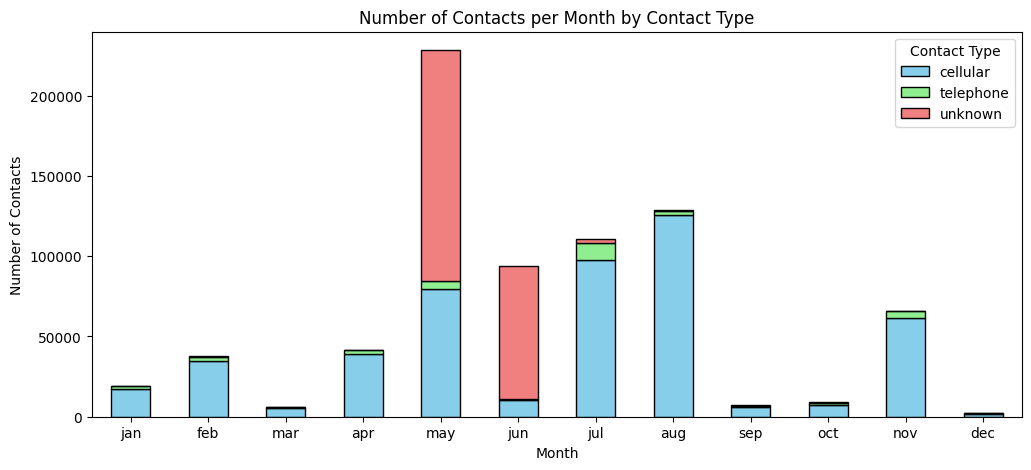

In [20]:
# Count of each contact type per month
contact_counts = df.groupby(['month','contact']).size().unstack(fill_value=0).reindex(month_order)

# Plot stacked bar chart
contact_counts.plot(
    kind='bar', 
    stacked=True, 
    figsize=(12,5), 
    color=['skyblue','lightgreen','lightcoral'], 
    edgecolor='black'
)

plt.title('Number of Contacts per Month by Contact Type')
plt.xlabel('Month')
plt.ylabel('Number of Contacts')
plt.xticks(rotation=0)
plt.legend(title='Contact Type')
plt.show()

In [21]:
# Create binary column for unknown contact
df['contact_unknown'] = (df['contact'] == 'unknown').astype(int)

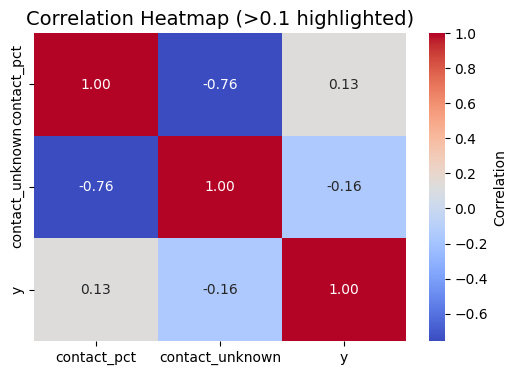

In [22]:
# Reorder columns
df_ordered = df[['contact_pct','contact_unknown','y']]

# Compute correlation matrix
corr = df_ordered.corr()

# Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Correlation'})

# Draw group separators
cat_end = len(categorical_cols)
num_end = len(categorical_cols) + len(numerical_cols)

plt.title("Correlation Heatmap (>0.1 highlighted)", fontsize=14)
plt.show()

/var/folders/4v/fw_22b1s72vb76mq4w8b6c5r0000gq/T/ipykernel_26321/554769093.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  brand_new_unknown.groupby(['month', 'duration_group'])


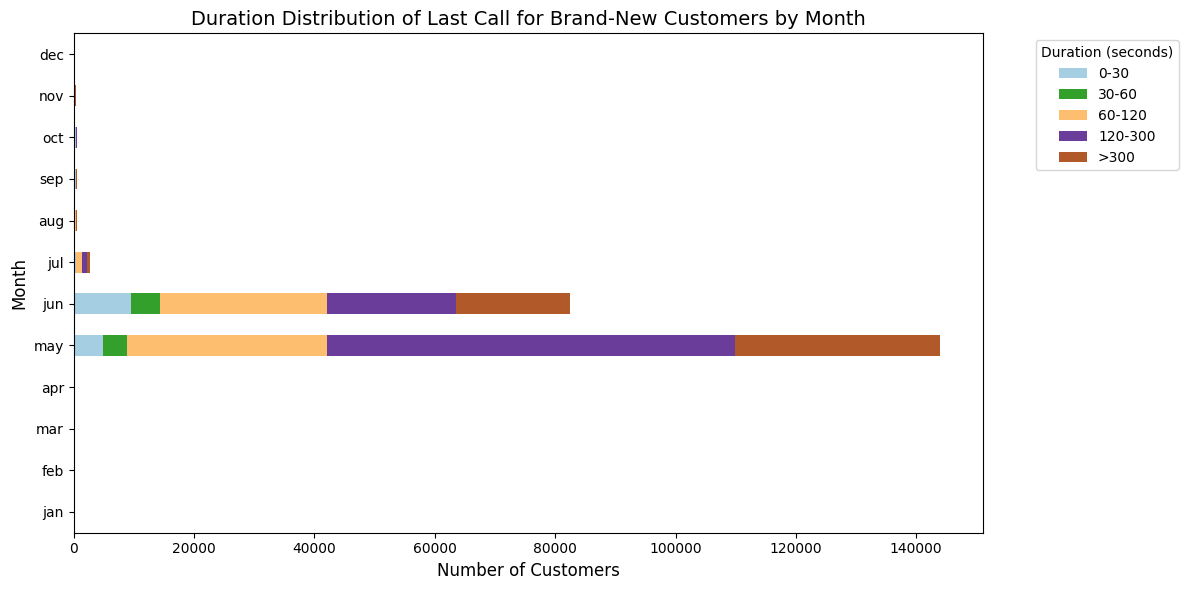

In [23]:
# --- Filter brand-new customers ---
brand_new_unknown = df[(df['previous'] == 0) & 
               (df['pdays'] == -1) & 
               (df['poutcome'] == 'unknown') &
               (df['contact'] == 'unknown')].copy()

# --- Define duration bins (seconds) ---
bins = [0, 30, 60, 120, 300, float('inf')]
labels = ['0-30', '30-60', '60-120', '120-300', '>300']

# --- Create duration group column ---
brand_new_unknown['duration_group'] = pd.cut(brand_new_unknown['duration'], bins=bins, labels=labels, include_lowest=True)

# --- Month order ---
month_order = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

# --- Group by month and duration group ---
duration_counts = (
    brand_new_unknown.groupby(['month', 'duration_group'])
    .size()
    .unstack(fill_value=0)
    .reindex(month_order)
)

# --- Plot stacked horizontal bar chart ---
duration_counts.plot(
    kind='barh',
    stacked=True,
    figsize=(12, 6),
    colormap='Paired'
)

plt.title('Duration Distribution of Last Call for Brand-New Customers by Month', fontsize=14)
plt.xlabel('Number of Customers', fontsize=12)
plt.ylabel('Month', fontsize=12)
plt.legend(title='Duration (seconds)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### default

"default" column carry extreme imbalance classes with ~98.3% "No" and only 1.7% "Yes". 

Heatmap shows weak/no correlation with the target y and with other predictors.

Action: drop "default"

### education

Heatmap shows weak correlation with the target y.

"education" has higher correlation with "age" and "job". However this only explain who subscribe, not an indicator for subscription rate.

Action: Apply label encoding.

### age

The heatmap of balance by job and age group shows that people aged 65+ have substantially higher balances than other age groups, regardless of job title.

Action: Create new column "age_group" to reduce dimension of data.

In [24]:
# Define age bins
age_bins = [18, 25, 35, 45, 55, 65, 100]
age_labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels)

In [25]:
# median balance pivot by age group
pivot_agegroup = df.pivot_table(
    index='job',
    columns='age_group',
    values='balance',
    aggfunc = 'median',
    ).fillna(0)

/var/folders/4v/fw_22b1s72vb76mq4w8b6c5r0000gq/T/ipykernel_26321/768784114.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_agegroup = df.pivot_table(


/var/folders/4v/fw_22b1s72vb76mq4w8b6c5r0000gq/T/ipykernel_26321/3432917138.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pivot_filled.applymap(lambda x: f"{x:,.0f}"),


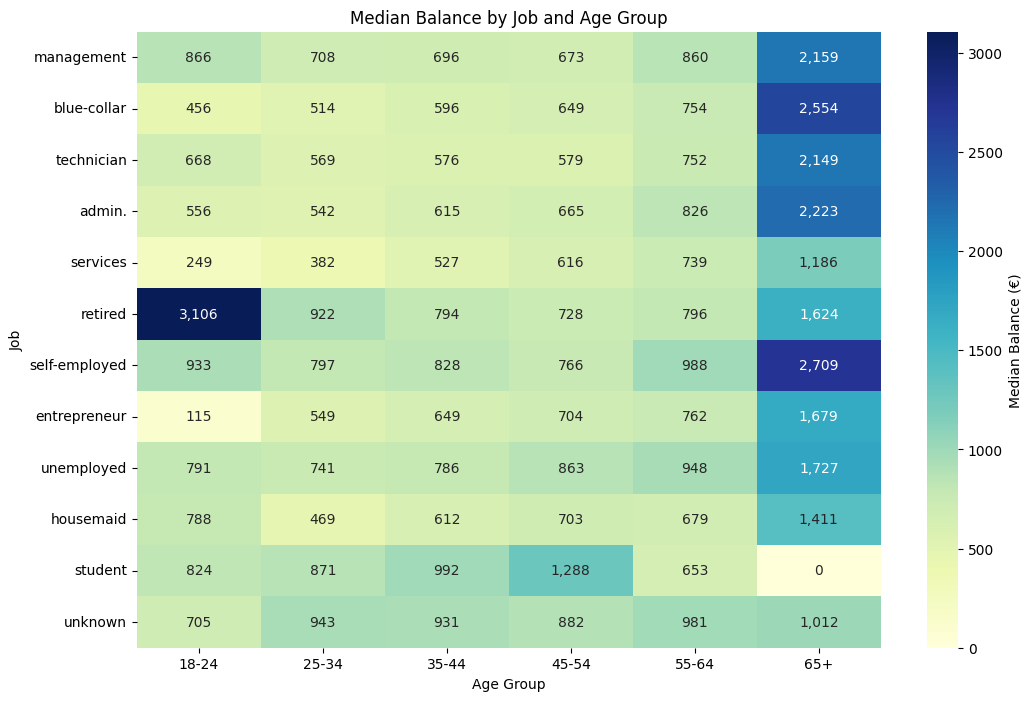

In [26]:
# Reindex pivot
pivot_filled = pivot_agegroup.reindex([
    'management', 'blue-collar', 'technician', 'admin.', 'services',
    'retired', 'self-employed', 'entrepreneur', 'unemployed', 'housemaid',
    'student', 'unknown'
])

# Create figure and axes if not already defined
fig, axes = plt.subplots(1, 1, figsize=(12, 8))  # single subplot

# Left Heatmap: Median Balance by Job and Age Group
sns.heatmap(
    pivot_filled,
    annot=pivot_filled.applymap(lambda x: f"{x:,.0f}"),
    fmt="", 
    cmap="YlGnBu",
    cbar_kws={'label': 'Median Balance (€)'},
    ax=axes
)

axes.set_title('Median Balance by Job and Age Group')
axes.set_xlabel('Age Group')
axes.set_ylabel('Job')

plt.show()

### job

Analysis of job, age and balance indicates that it's possible to group jobs into different clusters that are similar.

Action: Create "job_group" columns with 4 group names: Senior (management, retired), Student (student), Worker (admin, blue-collar, entrepreneur, housemaid, technician), and Independent (unemployed, unknown, self-employed).


In [27]:
# median balance pivot by age group
pivot = df.pivot_table(
    index='job',
    columns='age',
    values='balance').fillna(0)

In [28]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pivot_agegroup)

# PCA to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create DataFrame with PCA coordinates
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'], index=pivot_agegroup.index)
pca_df

,PC1,PC2
job,,
admin.,-1.332626,0.302926
blue-collar,-1.810321,0.063485
entrepreneur,-1.052815,-0.726725
housemaid,-1.174863,-1.301029
management,-0.340011,0.864928
retired,1.750013,1.261648
self-employed,0.602705,2.123633
services,-1.989889,-1.360680
student,3.660712,-2.768086


In [29]:
# Choose number of clusters
kmeans = KMeans(n_clusters=4, random_state=42)
pca_df['Cluster'] = kmeans.fit_predict(X_scaled)
pca_df

,PC1,PC2,Cluster
job,,,
admin.,-1.332626,0.302926,2
blue-collar,-1.810321,0.063485,2
entrepreneur,-1.052815,-0.726725,2
housemaid,-1.174863,-1.301029,2
management,-0.340011,0.864928,0
retired,1.750013,1.261648,0
self-employed,0.602705,2.123633,3
services,-1.989889,-1.360680,2
student,3.660712,-2.768086,1


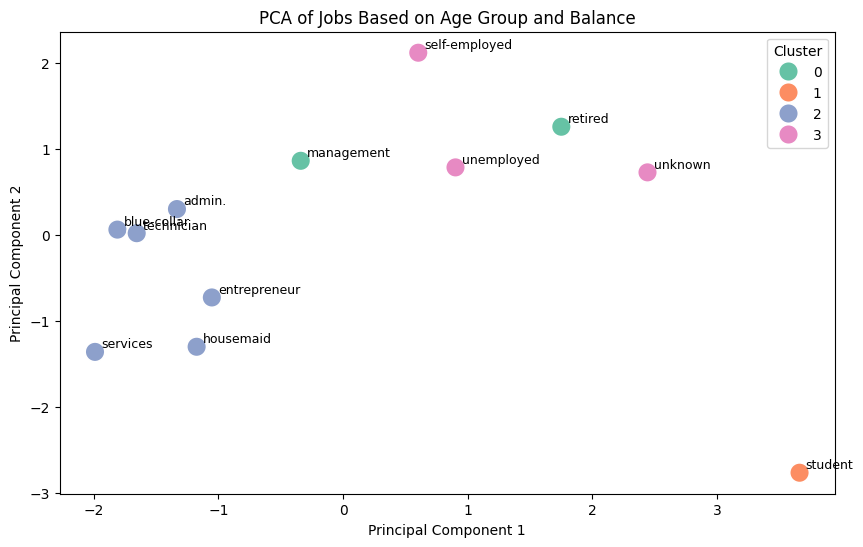

In [30]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PC1', y='PC2',
    data=pca_df,
    hue='Cluster',
    palette='Set2',
    s=200
)

# Add job labels
for job in pca_df.index:
    plt.text(
        x=pca_df.loc[job, 'PC1'] + 0.05,
        y=pca_df.loc[job, 'PC2'] + 0.05,
        s=job,
        fontsize=9
    )

plt.title('PCA of Jobs Based on Age Group and Balance')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

### marital

"marital" has weak correlation to target y, which mean "marital" alone doesn't strongly predict subscription.

"marital" has slightly higher correlation to only one variable "age", that's expected.

Action: Keep this column, apply label encoding. Consider drop this column for dimension reduction purpose.


/var/folders/4v/fw_22b1s72vb76mq4w8b6c5r0000gq/T/ipykernel_26321/1211404376.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='marital', y='age', data=df, palette='Set2')


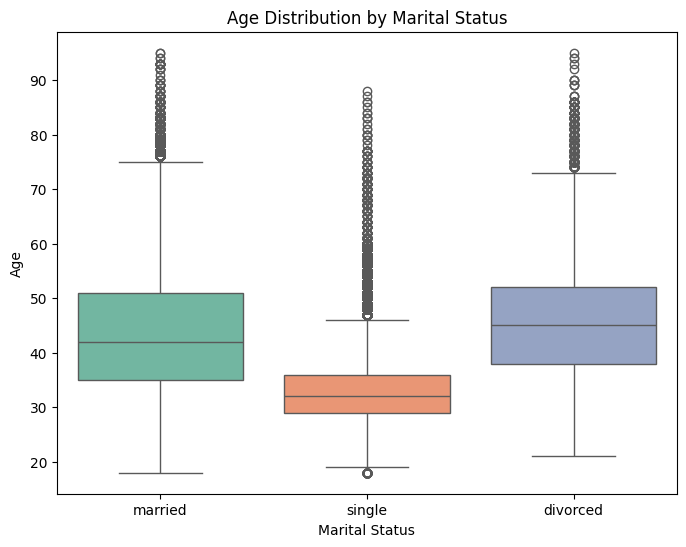

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.boxplot(x='marital', y='age', data=df, palette='Set2')
plt.title('Age Distribution by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Age')
plt.show()

### month

High subscription rate months likes Mar (57%), Sep (53%), Dec (51%), Oct (49%) are likely strategically targeted campaigns, e.g., quarter-end promotions, special banking offers, or months when clients are more likely to respond.

Low subscription months coincide with summer or holiday periods, e.g., May–August in many countries, when clients may be on vacation or less responsive.

Inverse relationship between number of calls and subscription rate: High subscription rate months with few calls. Low subscription rate months with many calls

Action: Keep the month as it is. Apply label encoding.

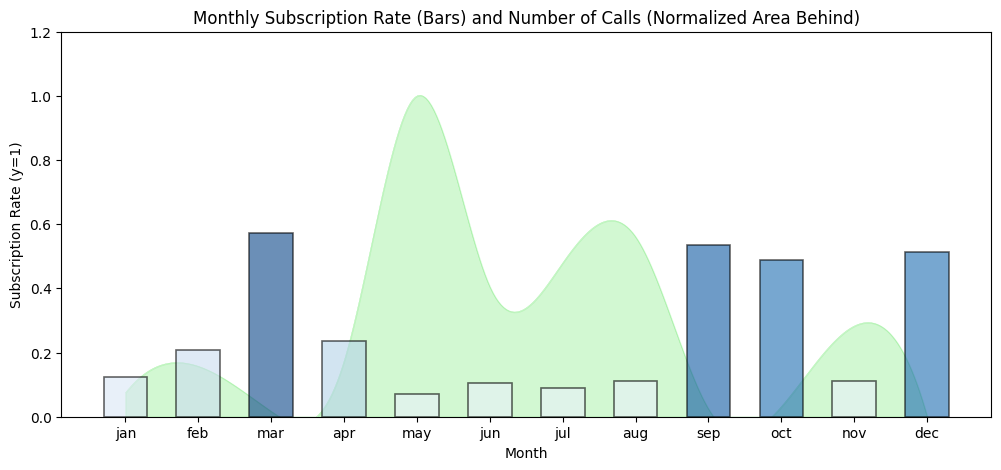

In [32]:
# Metrics
subscription_rate = df.groupby('month')['y'].mean().reindex(month_order)
num_calls = df['month'].value_counts().reindex(month_order)

# Gradient for subscription rate
norm = (subscription_rate - subscription_rate.min()) / (subscription_rate.max() - subscription_rate.min())
colors = sns.color_palette("Blues", n_colors=len(subscription_rate))
bar_colors = [colors[int(v*(len(subscription_rate)-1))] for v in norm]

# X-axis numeric for months
x = np.arange(len(month_order))

# Smooth curve for number of calls (normalize to 0–1 for visualization)
num_calls_norm = (num_calls - num_calls.min()) / (num_calls.max() - num_calls.min())
x_smooth = np.linspace(x.min(), x.max(), 300)
spl = make_interp_spline(x, num_calls_norm.values, k=3)
num_calls_smooth = spl(x_smooth)

# Plot
fig, ax1 = plt.subplots(figsize=(12,5))

# 1. Area plot for normalized number of calls
ax1.fill_between(x_smooth, num_calls_smooth, color='lightgreen', alpha=0.4, zorder=1)
ax1.plot(x_smooth, num_calls_smooth, color='lightgreen', linewidth=0.2, zorder=1)

# 2. Bars for subscription rate (in front)
ax1.bar(
    x, 
    subscription_rate.values, 
    color=bar_colors, 
    width=0.6, 
    alpha=0.6,
    zorder=2, 
    edgecolor='black',   
    linewidth=1.2        
)
ax1.set_xticks(x)
ax1.set_xticklabels(month_order)
ax1.set_ylim(0, 1.2) 
ax1.set_xlabel('Month')
ax1.set_ylabel('Subscription Rate (y=1)')

plt.title('Monthly Subscription Rate (Bars) and Number of Calls (Normalized Area Behind)')
plt.show()

### housing

Call distribution varies month by month:

Some months focus heavily on clients with housing loans (e.g., May, Jun, Jul). It could be the result of a compaign that targeted new customer with housing loan.

Action: Keep housing, apply label encoding.

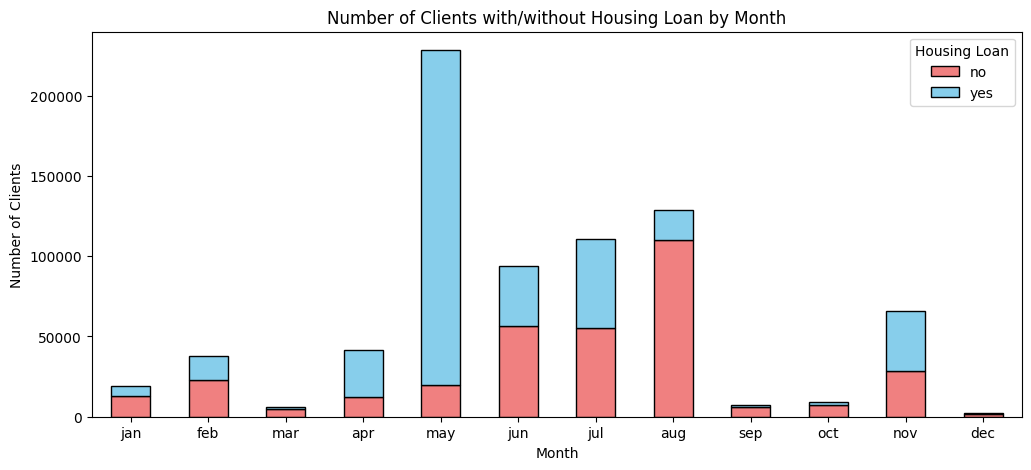

In [33]:
# Ensure month order
month_order = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

# Aggregate housing counts per month
housing_month = df.groupby(['month','housing']).size().unstack(fill_value=0).reindex(month_order)

# Plot stacked bar chart
housing_month.plot(
    kind='bar', 
    stacked=True, 
    figsize=(12,5),
    color=['lightcoral', 'skyblue'],  # no vs yes
    edgecolor='black'
)

plt.title('Number of Clients with/without Housing Loan by Month')
plt.xlabel('Month')
plt.ylabel('Number of Clients')
plt.xticks(rotation=0)
plt.legend(title='Housing Loan')
plt.show()


### loan

Personal loan have low correlation to all variables, including target 'y'. 

Subscription rate of clients with no personal loan and no housing loan are higher than the others.

Action: Keep the column.

In [34]:
# Compute subscription rate by housing and loan
pivot_rate = df.groupby(['housing', 'loan'])['y'].mean().unstack(fill_value=0)

print(pivot_rate)

loan           no       yes
housing                    
no       0.190437  0.063502
yes      0.080156  0.049529


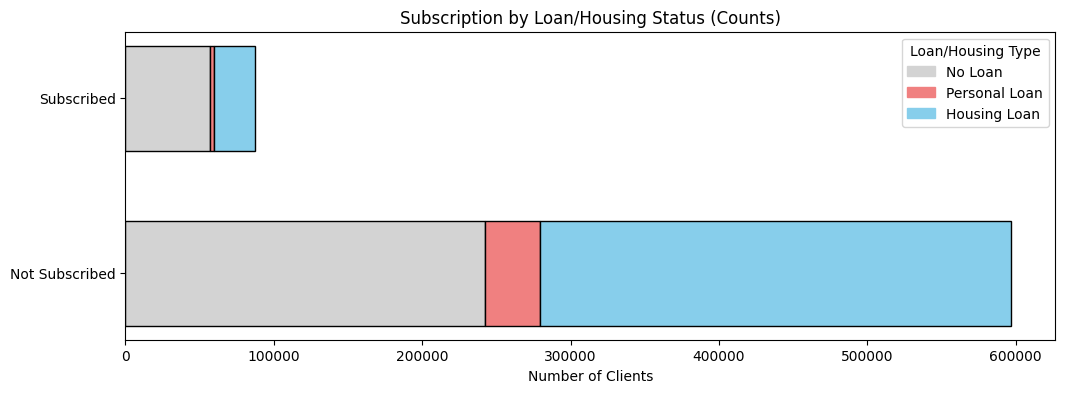

In [35]:
def loan_counts(sub_value):
    subset = df[df['y']==sub_value]
    return [
        ((subset['loan']=='no') & (subset['housing']=='no')).sum(),  # No Loan
        ((subset['loan']=='yes') & (subset['housing']=='no')).sum(), # Personal Loan
        ((subset['loan']=='no') & (subset['housing']=='yes')).sum()  # Housing Loan
    ]

# Counts for each subscription status
counts_no = np.array(loan_counts(0))
counts_yes = np.array(loan_counts(1))

labels = ['No Loan','Personal Loan','Housing Loan']
colors = ['lightgray','lightcoral','skyblue']

# Y positions
y = [0, 1]  # 0: Not Subscribed, 1: Subscribed
bar_height = 0.6

fig, ax = plt.subplots(figsize=(12,4))

# Stacked horizontal bars using cumulative sum
ax.barh(y[0], counts_no, left=np.cumsum(np.insert(counts_no, 0, 0))[:-1], color=colors, edgecolor='black', height=bar_height)
ax.barh(y[1], counts_yes, left=np.cumsum(np.insert(counts_yes, 0, 0))[:-1], color=colors, edgecolor='black', height=bar_height)

# Labels and legend
ax.set_yticks(y)
ax.set_yticklabels(['Not Subscribed','Subscribed'])
ax.set_xlabel('Number of Clients')
ax.set_title('Subscription by Loan/Housing Status (Counts)')
patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(labels))]
ax.legend(handles=patches, title='Loan/Housing Type')

plt.show()

### poutcomes

From heatmap analysis, poutcome_pct has high correlation with pdays (-0.89) and previous (-0.66).

Chi-square Test prove that poutcome and y are dependent. However, the correlation between poutcome and y are weak (-0.17).

By calculating the subscription rate (y = 1) for each poutcome category, "success" is strongly predictive (y=1 rate 0.76), while unknown, failure, and other are weak.

Most of the previous outcome of customer with 'previous' == 0 and pdays == -1 are "unknown" because they was not contacted or attended in any campaign before. Thus, those customer can be grouped as "new customer".

Action: Keep poutcome. Apply label encoding for tree-based models.

In [36]:
brand_new = df[(df['previous'] == 0) & 
               (df['pdays'] == -1)].copy()

# Check unique values of poutcome for these rows
unique_poutcome = brand_new['poutcome'].unique()
print("Unique 'poutcome' values for previous=0 and pdays=-1:")
print(unique_poutcome)

# Count of each value
poutcome_counts = brand_new['poutcome'].value_counts()
print("\nCounts of 'poutcome' for previous=0 and pdays=-1:")
print(poutcome_counts)

Unique 'poutcome' values for previous=0 and pdays=-1:
['unknown' 'failure' 'success' 'other']

Counts of 'poutcome' for previous=0 and pdays=-1:
poutcome
unknown    672407
failure         6
success         3
other           1
Name: count, dtype: int64


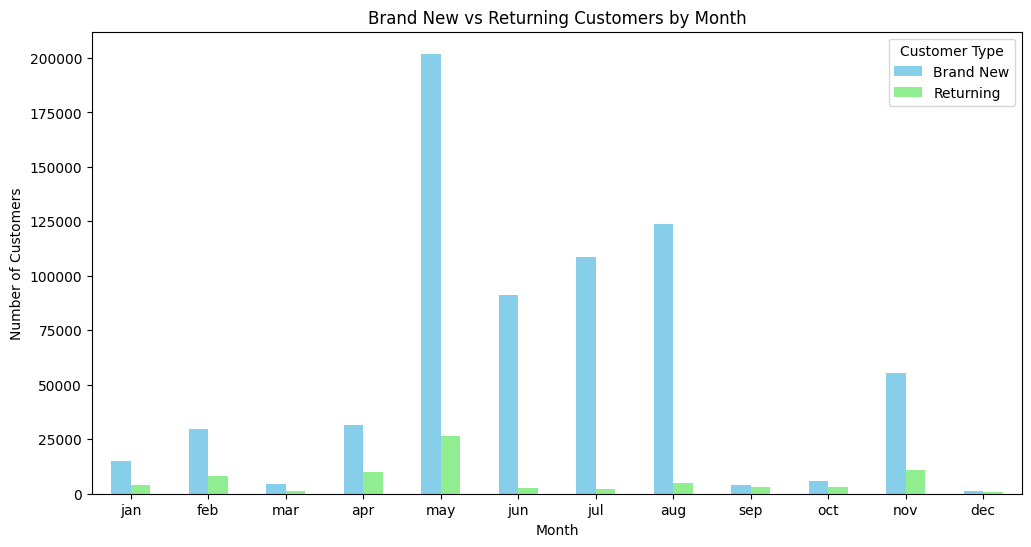

In [37]:
# Define old/returning customers
old_customer = df[~df.index.isin(brand_new.index)]

# Count per month
month_order = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

brand_new_count = brand_new['month'].str.lower().value_counts().reindex(month_order, fill_value=0)
old_customer_count = old_customer['month'].str.lower().value_counts().reindex(month_order, fill_value=0)

# Combine into one DataFrame
customer_counts = pd.DataFrame({
    'Brand New': brand_new_count,
    'Returning': old_customer_count
})

# Plot grouped bar chart
customer_counts.plot(
    kind='bar',
    figsize=(12,6),
    color=['skyblue','lightgreen']
)
plt.title('Brand New vs Returning Customers by Month')
plt.xlabel('Month')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.legend(title='Customer Type')
plt.show()

In [38]:
# --- Chi-square test ---
# Create contingency table
contingency_table = pd.crosstab(df['poutcome'], df['y'])

# Perform Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-square statistic: {chi2:.3f}")
print(f"P-value: {p:.3f}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:\n", expected)

# Interpretation
if p < 0.05:
    print("\nResult: Reject null hypothesis — poutcome and y are dependent.")
else:
    print("\nResult: Fail to reject null hypothesis — poutcome and y may be independent.")


Chi-square statistic: 71606.061
P-value: 0.000
Degrees of freedom: 3
Expected frequencies:
 [[ 39671.84517333   5443.15482667]
 [ 12965.12657067   1778.87342933]
 [ 15556.569056     2134.430944  ]
 [591318.4592      81131.5408    ]]

Result: Reject null hypothesis — poutcome and y are dependent.


In [39]:
df.groupby('poutcome')['y'].mean()

poutcome
failure    0.132794
other      0.166848
success    0.764004
unknown    0.101898
Name: y, dtype: float64

### balance

"balance" has a weak correlation (0.11) with "duration", which is a leakage.

"balance" has a weak correlation (0.12) with "y".

Action: Keep balance as it is.

### campaign

"campaign" has a weak correlation (0.18) with "day" and not correlate with "y". 

Action: Keep as numeric.

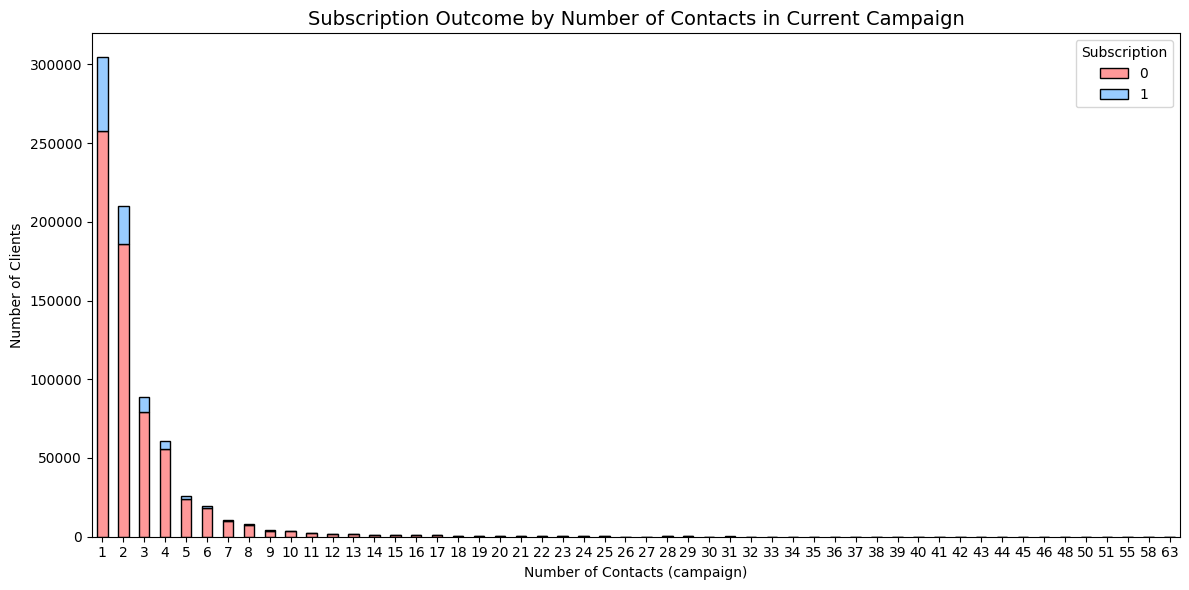

In [40]:
import matplotlib.pyplot as plt
import pandas as pd

# Count number of clients per campaign number grouped by subscription outcome
campaign_counts = df.groupby(['campaign', 'y']).size().unstack(fill_value=0)

# Plot stacked bar
campaign_counts.plot(
    kind='bar',
    stacked=True,
    figsize=(12,6),
    color=['#ff9999', '#99ccff'],
    edgecolor='black'
)

plt.title("Subscription Outcome by Number of Contacts in Current Campaign", fontsize=14)
plt.xlabel("Number of Contacts (campaign)")
plt.ylabel("Number of Clients")
plt.xticks(rotation=0)
plt.legend(title="Subscription")
plt.tight_layout()
plt.show()

### day

Action: Keep day as numeric.

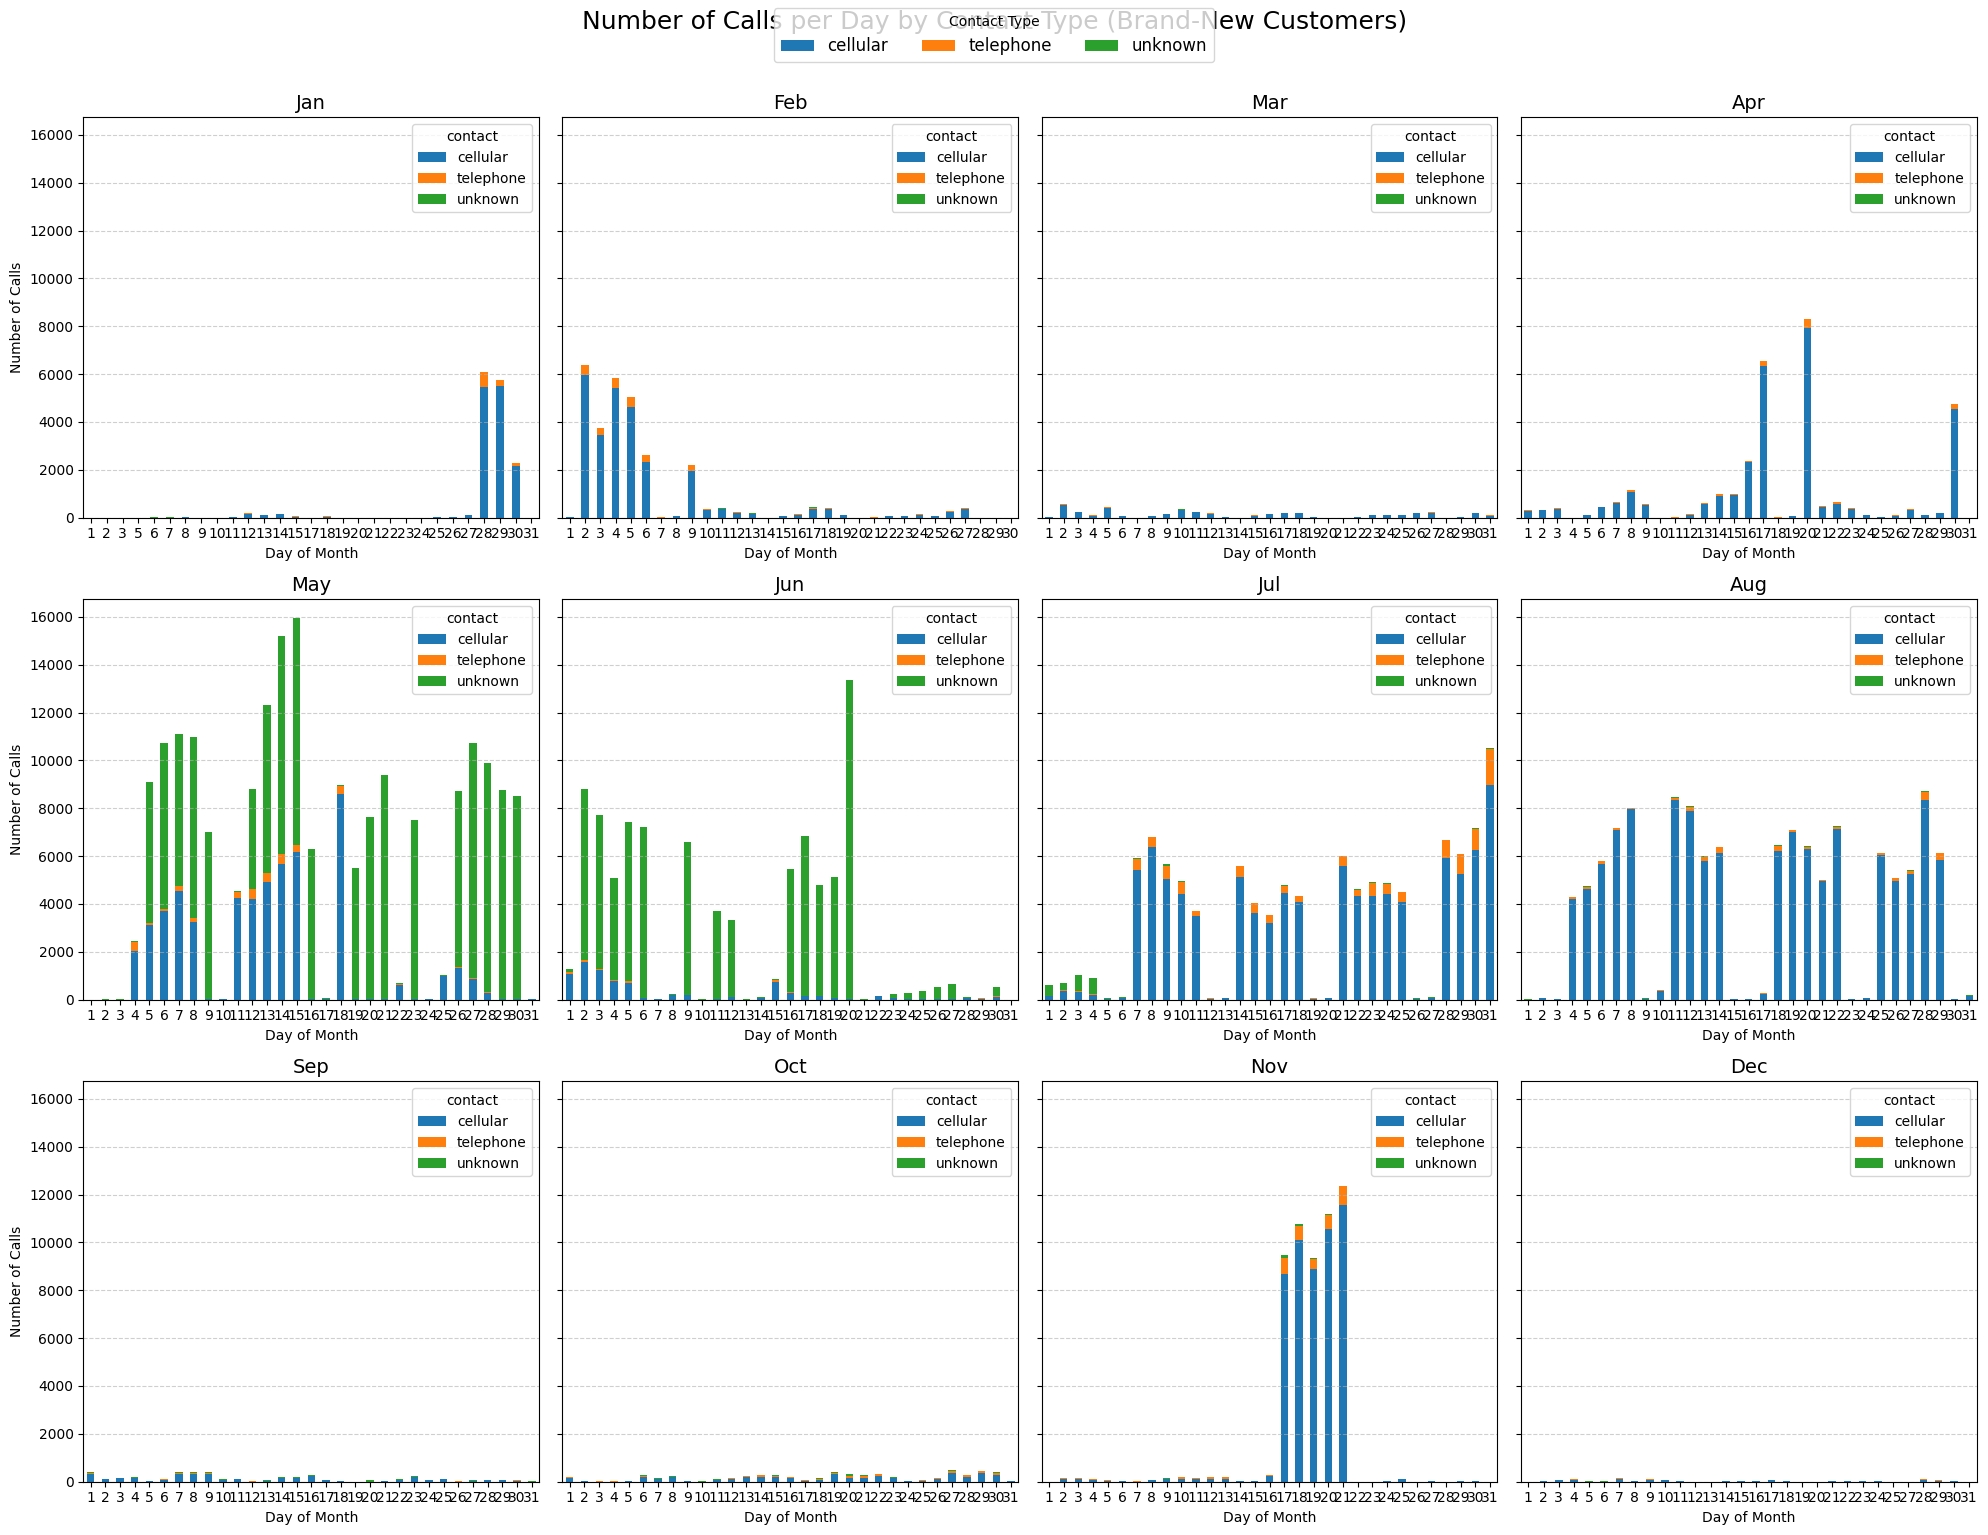

In [41]:
import matplotlib.pyplot as plt
import pandas as pd

# Define months in order
months_order = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

# Create subplots for all 12 months (3 rows × 4 columns)
fig, axes = plt.subplots(3, 4, figsize=(20, 15), sharey=True)
axes = axes.flatten()

for i, month in enumerate(months_order):
    # Filter data for the current month
    month_data = brand_new[brand_new['month'].str.lower() == month]

    # Group by day and contact type
    daily_counts = (
        month_data.groupby(['day', 'contact'])
        .size()
        .unstack(fill_value=0)
        .sort_index()
    )

    # Plot stacked bar for that month
    daily_counts.plot(
        kind='bar',
        stacked=True,
        ax=axes[i],
        color=['#1f77b4', '#ff7f0e', '#2ca02c']  # unknown, cellular, telephone
    )

    axes[i].set_title(f'{month.capitalize()}', fontsize=14)
    axes[i].set_xlabel('Day of Month')
    axes[i].set_ylabel('Number of Calls')
    axes[i].tick_params(axis='x', rotation=0)
    axes[i].grid(axis='y', linestyle='--', alpha=0.6)

# Add a single legend for the whole figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Contact Type', loc='upper center', ncol=3, fontsize=12)

plt.suptitle('Number of Calls per Day by Contact Type (Brand-New Customers)', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

### duration

As mentioned in the variable explaination, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. 

Action: Keep "duration" column for benchmarking model only, remove it for other models.

/var/folders/4v/fw_22b1s72vb76mq4w8b6c5r0000gq/T/ipykernel_26321/3847527596.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate_per_bin = df.groupby('duration_binned')['y'].mean()


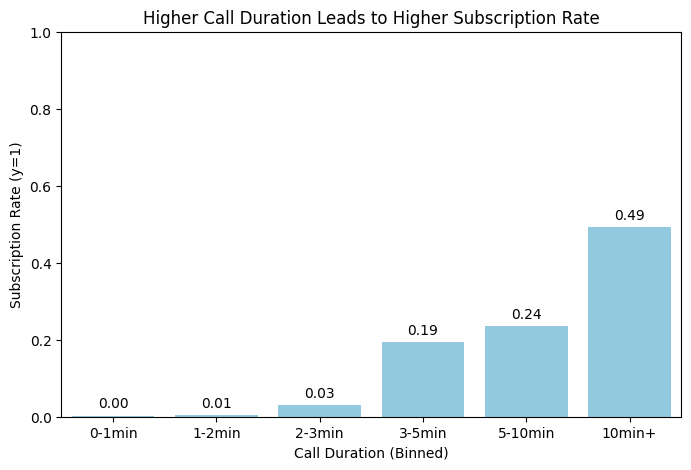

In [42]:
df['duration_binned'] = pd.cut(df['duration'], 
                               bins=[0, 60, 120, 180, 300, 600, df['duration'].max()],
                               labels=['0-1min', '1-2min', '2-3min', '3-5min', '5-10min', '10min+'])

rate_per_bin = df.groupby('duration_binned')['y'].mean()

plt.figure(figsize=(8,5))
sns.barplot(x=rate_per_bin.index, y=rate_per_bin.values, color='skyblue')
plt.title('Higher Call Duration Leads to Higher Subscription Rate')
plt.xlabel('Call Duration (Binned)')
plt.ylabel('Subscription Rate (y=1)')
plt.ylim(0, 1)
for i, v in enumerate(rate_per_bin.values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=10)
plt.show()

### pdays

The correlation of "pdays" and "previous" are high at 0.56. If a client was never contacted before (previous = 0), then pdays will usually be -1 (meaning "not contacted"). 

Clients contacted recently (31–90 days) have the highest subscription rate. Those never contacted or contacted very long ago have low subscription rates.

Action: Create a new feature "was_contact_before" where 0 = No, 1 = Yes.

In [43]:
# Replace -1 with NaN for distribution/bins
df['pdays_clean'] = df['pdays'].replace(-1, pd.NA)

# Binning pdays into ranges
bins = [-1, 0, 30, 90, 180, 365, df['pdays_clean'].max()]
labels = ['not_contacted', '0-30', '31-90', '91-180', '181-365', '366+']
df['pdays_binned'] = pd.cut(df['pdays'], bins=bins, labels=labels, include_lowest=True)

# Check proportion of y=1 per bin
proportion_per_bin = df.groupby('pdays_binned')['y'].mean()
print(proportion_per_bin)

pdays_binned
not_contacted    0.101903
0-30             0.153635
31-90            0.631907
91-180           0.354208
181-365          0.225462
366+             0.213610
Name: y, dtype: float64


/var/folders/4v/fw_22b1s72vb76mq4w8b6c5r0000gq/T/ipykernel_26321/834028350.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportion_per_bin = df.groupby('pdays_binned')['y'].mean()


### previous

"previous" has strong correlation to pdays (0.56) and poutcome (-0.66) but weak correlation to target 'y'. 

"previous" together with "pdays" indicate who is the new customer that was not contacted before.

Action: Keep previous.

# **Preprocessing Pipeline**

In [44]:
train = pd.read_csv("train.csv")

In [45]:

# Clean train data
train['job'] = train['job'].str.replace('admin.', 'admin', regex=False)
train = train.drop(columns=['default','duration'])

In [ ]:
# Feature Engineering Pipeline

class BankPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Age bins
        self.age_bins = [18, 25, 35, 45, 55, 65, 100]
        self.age_labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
        
        # Job clustering
        self.pca_clusters = {
            'admin.': 2, 'blue-collar': 2, 'entrepreneur': 2, 'housemaid': 2,
            'management': 0, 'retired': 0, 'self-employed': 3, 'services': 2,
            'student': 1, 'technician': 2, 'unemployed': 3, 'unknown': 3
        }
        self.cluster_mapping = {0: 'senior', 1: 'student', 2: 'worker', 3: 'independent'}
        self.job_to_group = {job: self.cluster_mapping[cluster] for job, cluster in self.pca_clusters.items()}
        
        # Columns to encode
        self.categorical_cols = [
            'poutcome', 'contact', 'education', 'marital', 'month',
            'housing', 'loan', 'job_group', 'age_group'
        ]
        self.le_dict = {}

    def _add_features(self, X):
        """Create derived columns consistently for both fit and transform"""
        X = X.copy()
        X['age_group'] = pd.cut(X['age'], bins=self.age_bins, labels=self.age_labels)
        X['job_group'] = X['job'].map(self.job_to_group)
        X['was_contacted_before'] = (X['pdays'] != -1).astype(int)
        return X

    def fit(self, X, y=None):
        X = self._add_features(X)
        for col in self.categorical_cols:
            le = LabelEncoder()
            le.fit(X[col].astype(str).fillna('Unknown'))
            self.le_dict[col] = le
        return self

    def transform(self, X):
        X = self._add_features(X)
        for col, le in self.le_dict.items():
            X[col] = le.transform(X[col].astype(str).fillna('Unknown'))
        
        drop_cols = ['id', 'job', 'age']
        return X.drop(columns=[c for c in drop_cols if c in X.columns])

In [48]:
# --- Create pipeline ---
preprocess_pipe = Pipeline([
    ('preprocessor', BankPreprocessor())
])

### SMOTE - Random Forest model

In [49]:
df = preprocess_pipe.fit_transform(train)

In [50]:
df.head()

,marital,education,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y,age_group,job_group,was_contacted_before
0,1,1,7,0,0,0,25,1,3,-1,0,3,0,2,4,0
1,1,1,514,0,0,2,18,6,1,-1,0,3,0,2,4,0
2,1,1,602,1,0,2,14,8,2,-1,0,3,0,2,4,0
3,2,1,34,1,0,2,28,8,2,-1,0,3,0,1,3,0
4,1,1,889,1,0,0,3,3,1,-1,0,3,1,1,4,0


In [51]:
X = df.drop(columns=['y'])
y = df['y']

In [52]:
X_resampled, y_resampled = SMOTE().fit_resample(X, y)

In [53]:
print(sorted(Counter(y_resampled).items()))

[(0, 659512), (1, 659512)]


In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [55]:
rf_smote_model = RandomForestClassifier()

In [56]:
rf_smote_model.fit(X_train,y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [57]:
y_probs = rf_smote_model.predict_proba(X_test)[:, 1]

In [58]:
print(f"AUC-ROC: {roc_auc_score(y_test, y_probs):.8f}")

AUC-ROC: 0.95206252


In [59]:
y_pred = rf_smote_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89    131662
           1       0.88      0.90      0.89    132143

    accuracy                           0.89    263805
   macro avg       0.89      0.89      0.89    263805
weighted avg       0.89      0.89      0.89    263805



In [61]:
import joblib, gzip

In [62]:
joblib.dump(rf_smote_model, gzip.open('model_smote.dat.gz', "wb"))

KeyboardInterrupt: 

### SMOTENC - Random Forest Model